# Graph Transformers at Scale: Global, Sparse and Hybrid Attention

## Project Overview

This notebook implements and analyzes scalable graph transformers focusing on three attention mechanisms:

1. **GOAT**: Global attention with approximate global patterns
2. **Exphormer**: Sparse attention using expander graph sparsity  \
3. **G2LFormer**: Hybrid global-to-local attention

**Research Goals**: 
1. **Complexity vs. accuracy tradeoffs** across different attention mechanisms
2. **Homophily/heterophily robustness** - performance across different graph types
3. **Ablations on positional encodings and global-token designs**

**Datasets**: OGB, ZINC, Peptides (long-range graph benchmarks)

In [1]:
import sys
sys.path.append('src')

import torch
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - using CPU")

Device: cuda
PyTorch version: 2.6.0+cu124
CUDA device: NVIDIA GeForce RTX 3090
CUDA memory: 25.8 GB


## Dataset Loading and Analysis

Load and analyze the datasets to understand their characteristics for graph transformer research.


In [2]:
from utils.data import (
    load_molhiv_dataset,
    load_peptides_func_dataset,
    load_zinc_dataset,
    print_dataset_summary,
)

### OGB Dataset: ogbg-molhiv

Load the molecular HIV classification dataset from Open Graph Benchmark for classification task.


In [3]:
dataset_molhiv, split_molhiv = load_molhiv_dataset()

print("Dataset: ogbg-molhiv")
print(f"Total graphs: {len(dataset_molhiv):,}")
print(f"Train: {len(split_molhiv['train']):,}, Val: {len(split_molhiv['valid']):,}, Test: {len(split_molhiv['test']):,}")

print_dataset_summary(dataset_molhiv)

Dataset: ogbg-molhiv
Total graphs: 41,127
Train: 32,901, Val: 4,113, Test: 4,113
DATASET SUMMARY: OGBG-MOLHIV
Total graphs: 41,127
Avg nodes: 18.0 ± 8.9
Avg edges: 37.6 ± 19.0
Avg degree: 2.1 ± 0.7
Node range: 4 - 42
Edge range: 6 - 88


### LRGB Dataset: Peptides-func

Load the peptide function prediction dataset from Long Range Graph Benchmark (LRGB) for regression task.


In [4]:
dataset_peptides_func, split_peptides_func = load_peptides_func_dataset()

print("Dataset: Peptides-func")
print(f"Total graphs: {len(dataset_peptides_func):,}")
print(f"Train: {len(split_peptides_func['train']):,}, Val: {len(split_peptides_func['valid']):,}, Test: {len(split_peptides_func['test']):,}")

print_dataset_summary(dataset_peptides_func)

Dataset: Peptides-func
Total graphs: 10,873
Train: 8,698, Val: 1,087, Test: 1,088
DATASET SUMMARY: PEPTIDES-FUNC
Total graphs: 10,873
Avg nodes: 173.0 ± 96.9
Avg edges: 352.2 ± 197.0
Avg degree: 2.0 ± 0.8
Node range: 31 - 394
Edge range: 62 - 808


### PyTorch Geometric Dataset: ZINC

Load the molecular property regression dataset from PyTorch Geometric for regression task.


In [5]:
dataset_zinc, split_zinc = load_zinc_dataset()

print("Dataset: ZINC")
print(f"Total graphs: {len(dataset_zinc):,}")
print(f"Train: {len(split_zinc['train']):,}, Val: {len(split_zinc['valid']):,}, Test: {len(split_zinc['test']):,}")

print_dataset_summary(dataset_zinc)

Dataset: ZINC
Total graphs: 10,000
Train: 8,000, Val: 1,000, Test: 1,000
DATASET SUMMARY: ZINC
Total graphs: 10,000
Avg nodes: 23.5 ± 4.6
Avg edges: 50.5 ± 11.0
Avg degree: 2.1 ± 0.7
Node range: 16 - 33
Edge range: 32 - 74


# Data Analysis for Graph Transformers

This section provides comprehensive analysis of our datasets to understand their characteristics for transformer benchmarking.


In [6]:
from utils.analysis import (
    visualize_sample_graphs,
    plot_graph_size_distributions,
    analyze_graph_properties,
    plot_graph_properties_analysis,
    plot_graph_relationships,
)

datasets = [dataset_molhiv, dataset_peptides_func, dataset_zinc]

## Graph Visualizations


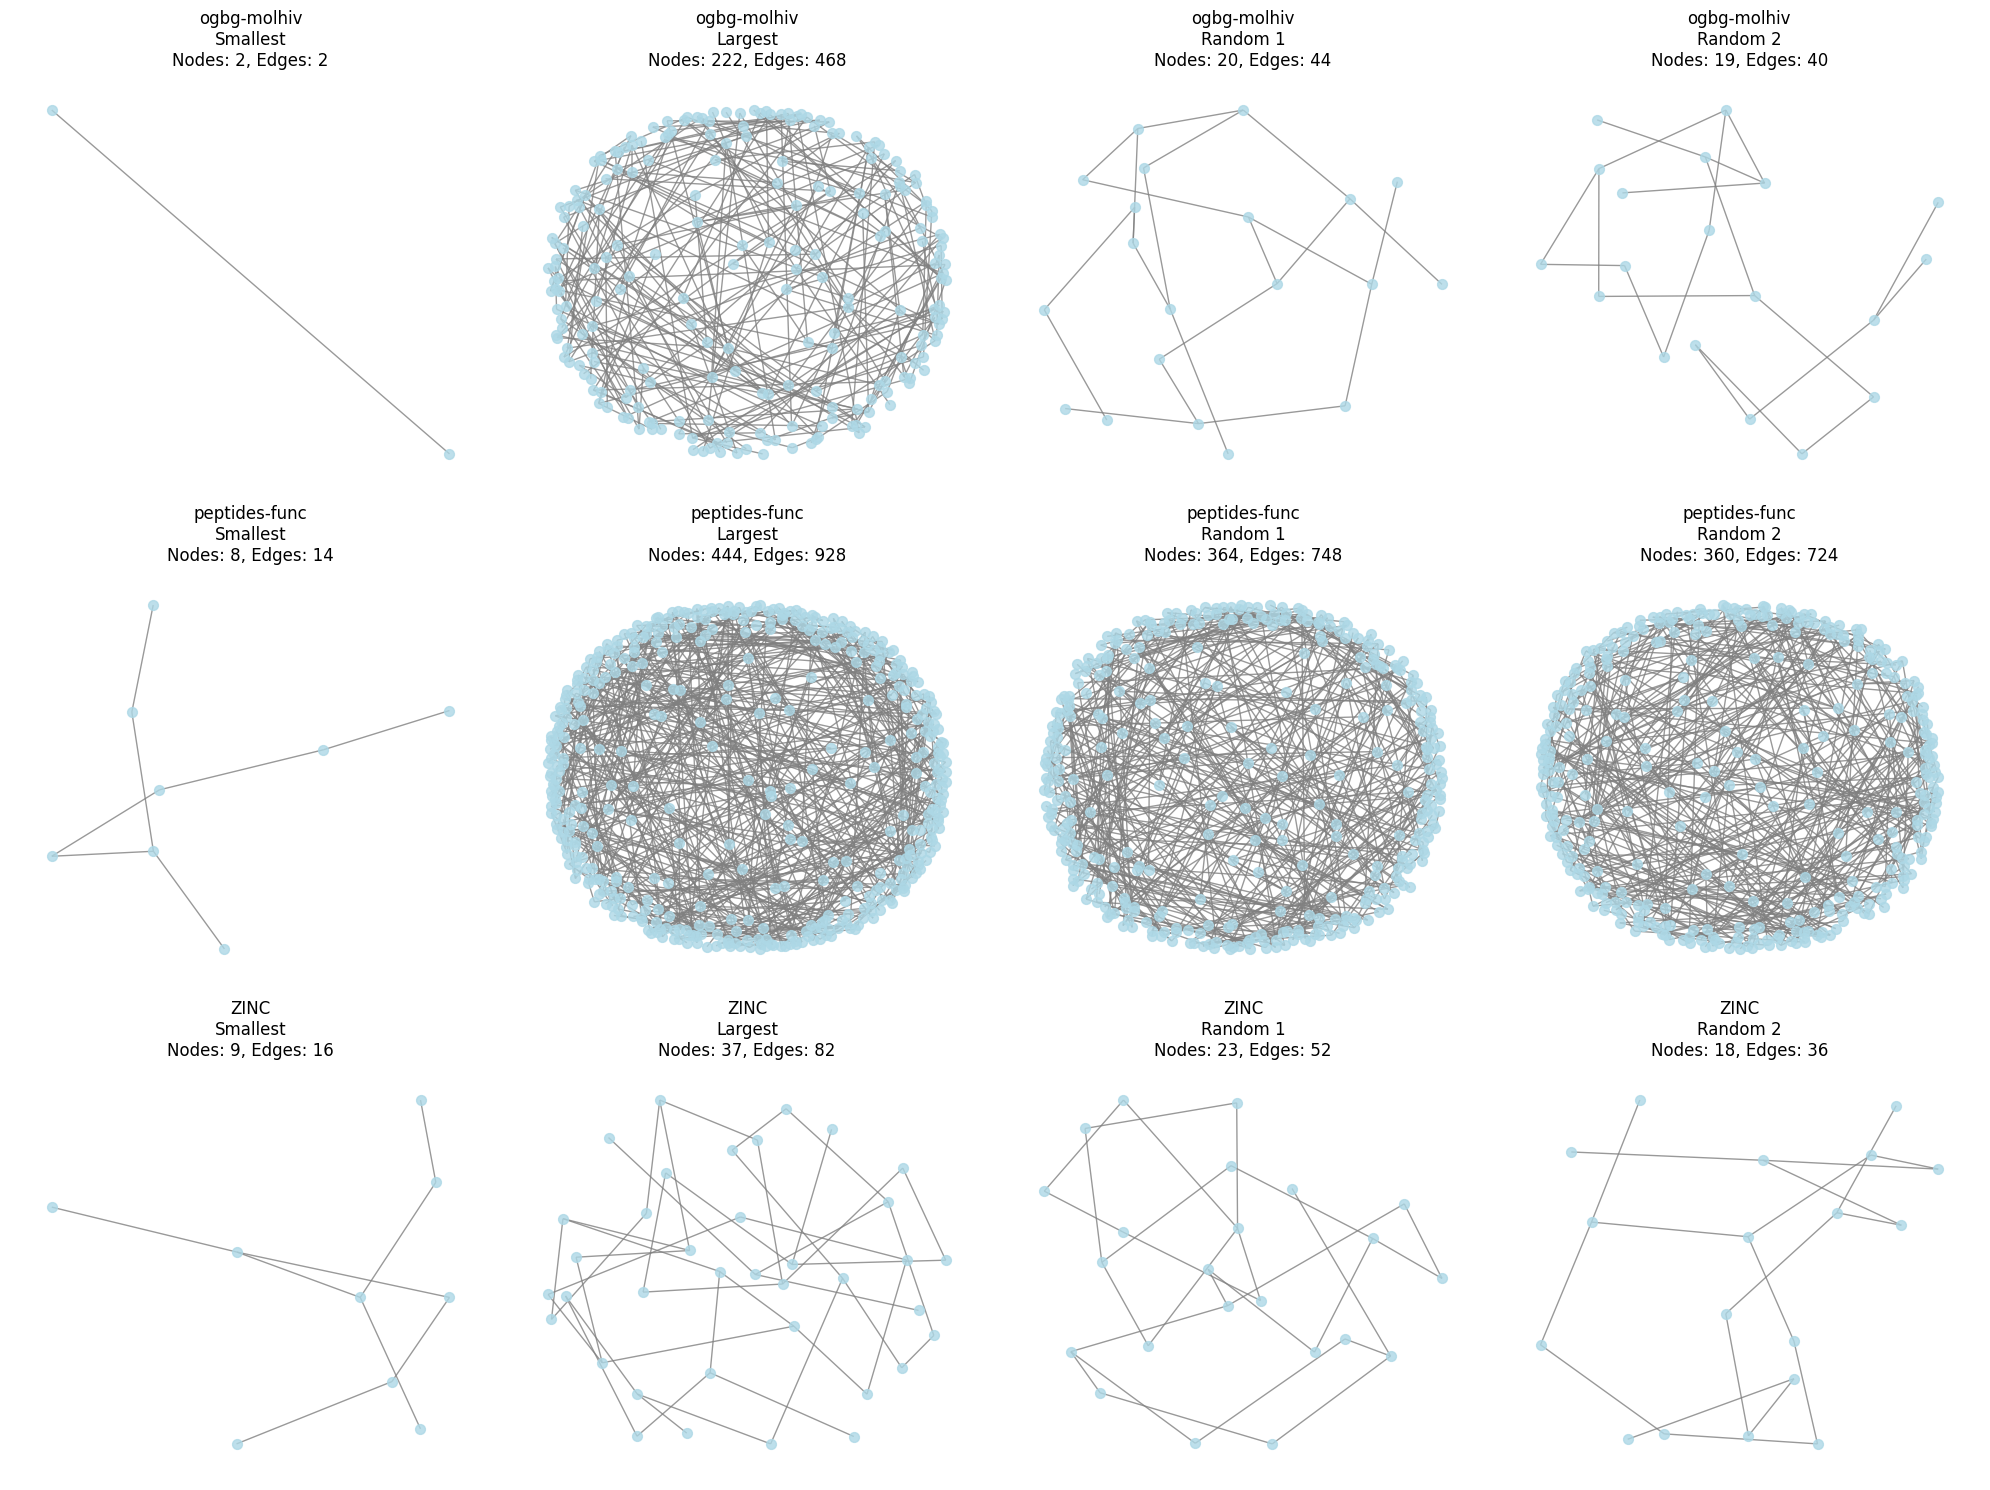

In [7]:
visualize_sample_graphs(datasets)

## Graph Properties Analysis

These histograms show the frequency distribution of node and edge counts across all datasets, revealing the typical graph sizes.

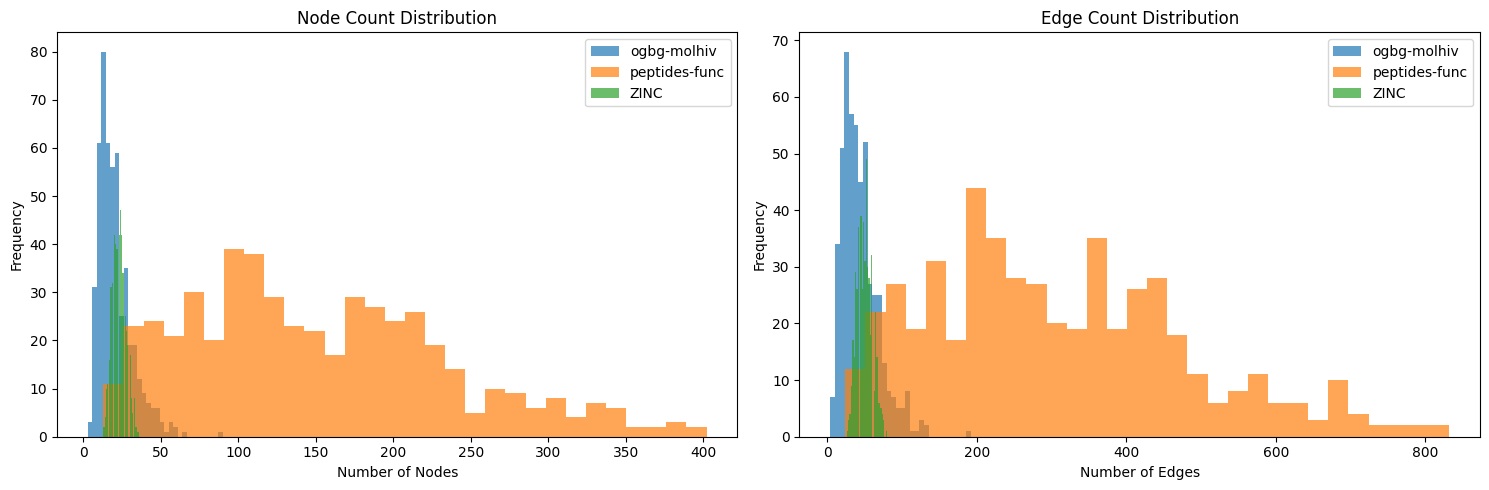

In [8]:
plot_graph_size_distributions(datasets)

Comparison of graph diameter, density, and shortest path distributions across all datasets.



Analyzing ogbg-molhiv...

Analyzing peptides-func...

Analyzing ZINC...


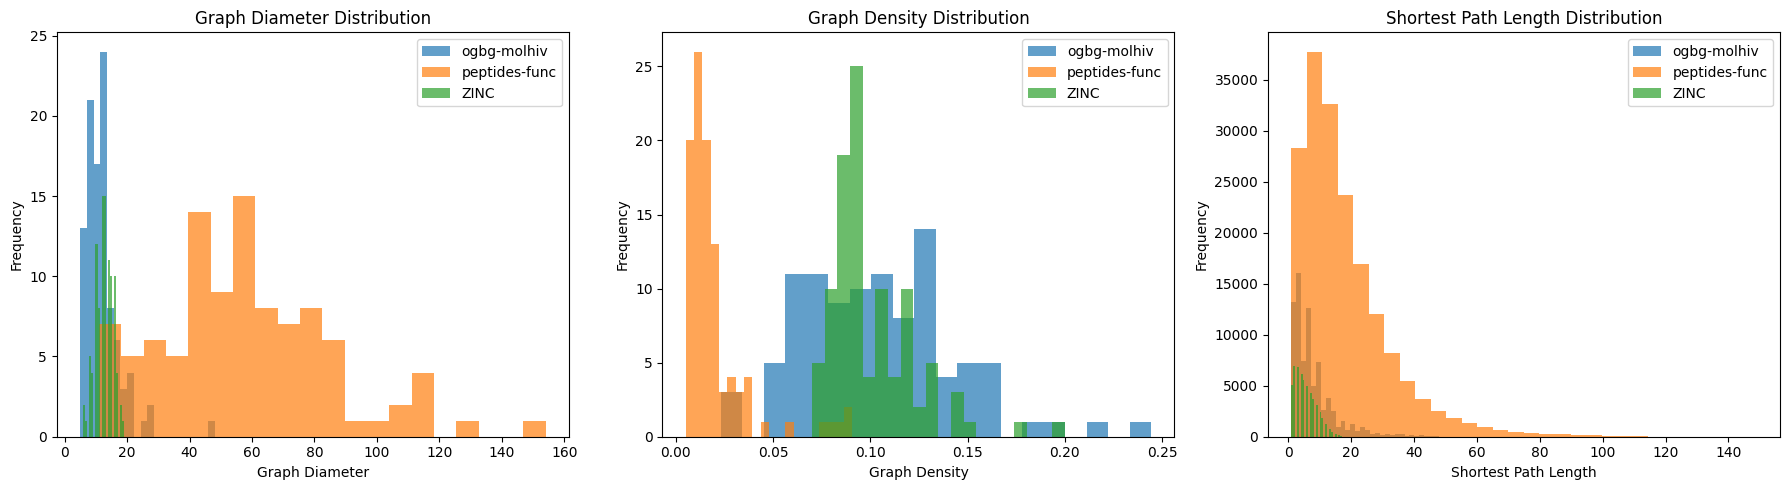

In [9]:
graph_properties = analyze_graph_properties(datasets, sample_size=100)
plot_graph_properties_analysis(graph_properties)

### Graph Size and Structure Relationships

Analyze the relationships between graph size, diameter, density, and other structural properties.


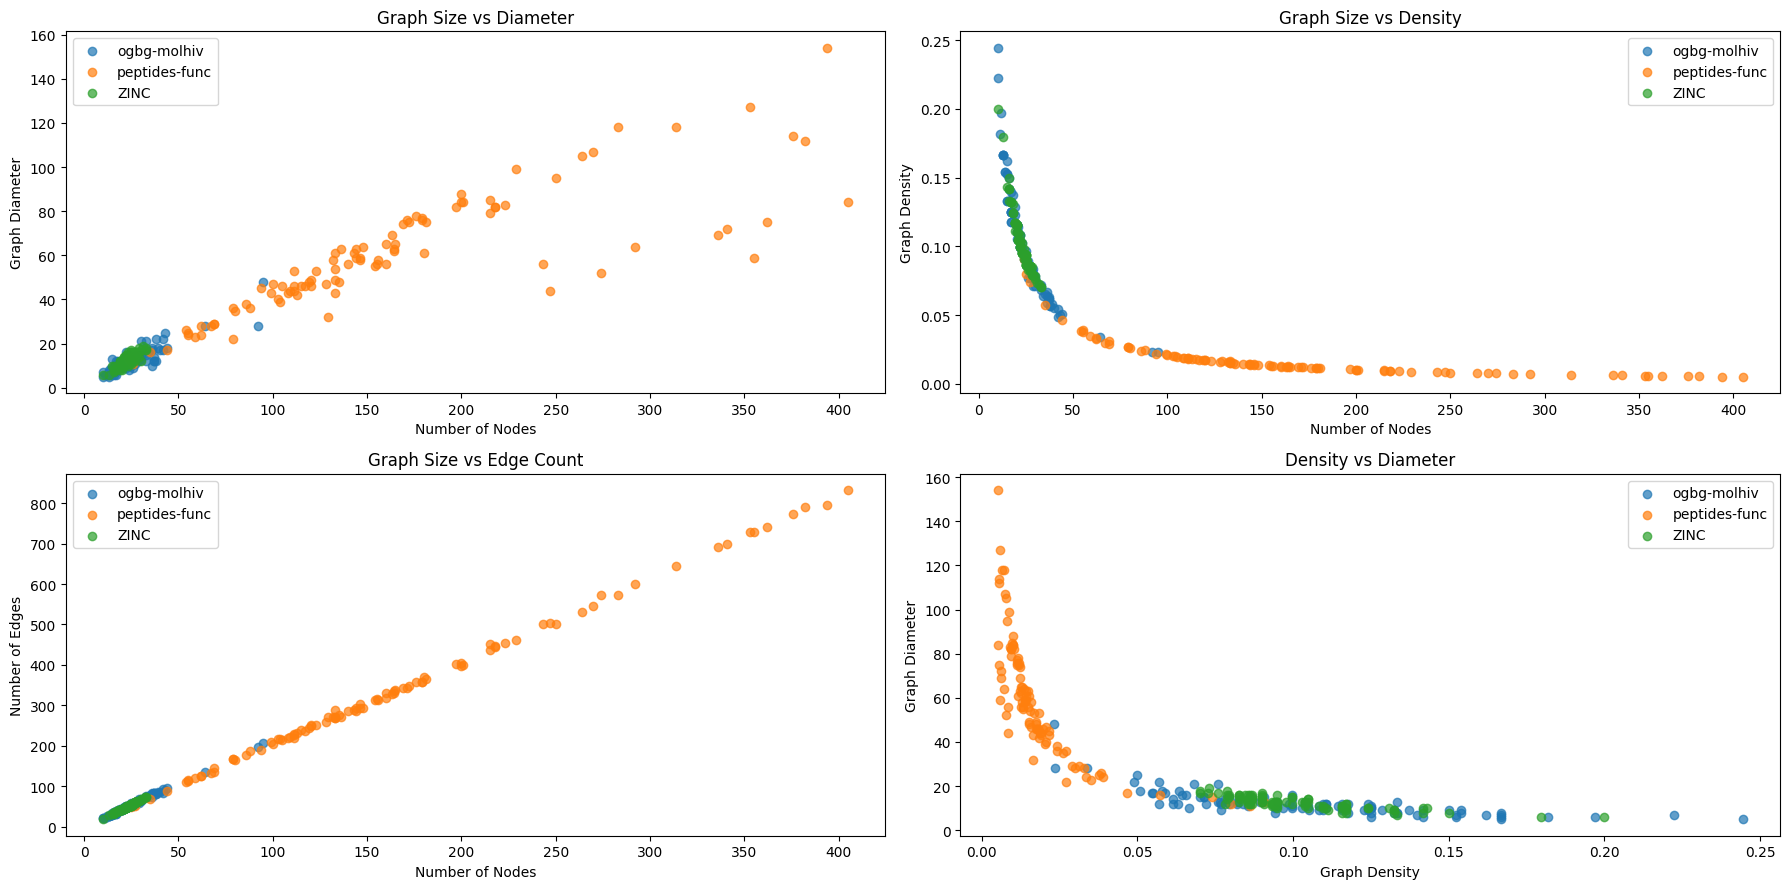

In [10]:
plot_graph_relationships(graph_properties)

## Model Implementation and Training


In [11]:
# Import models and training utilities
from utils.models import get_model, G2LFormer, GCNBaseline, GATBaseline
from utils.training import train_model, evaluate, get_task_type, PerformanceTracker
from torch_geometric.loader import DataLoader
import torch.nn as nn

print("Models and training utilities imported")

Models and training utilities imported


### Prepare Data Loaders

Create data loaders for training, validation, and testing.

In [12]:
# Prepare data loaders for each dataset
def create_data_loaders(dataset, split_idx, batch_size=32):
    """Create train/val/test data loaders."""
    train_loader = DataLoader(
        [dataset[i] for i in split_idx['train']],
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        [dataset[i] for i in split_idx['valid']],
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = DataLoader(
        [dataset[i] for i in split_idx['test']],
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, val_loader, test_loader

# Create loaders for MolHIV (classification task)
molhiv_train, molhiv_val, molhiv_test = create_data_loaders(
    dataset_molhiv, split_molhiv, batch_size=32
)

# Get input dimension from first graph
sample_graph = dataset_molhiv[0]
input_dim = sample_graph.x.size(1)
print("Data loaders created for MolHIV")
print("  Input dimension:", input_dim)
print("  Train batches:", len(molhiv_train))
print("  Val batches:", len(molhiv_val))
print("  Test batches:", len(molhiv_test))

Data loaders created for MolHIV
  Input dimension: 9
  Train batches: 1029
  Val batches: 129
  Test batches: 129


### Train G2LFormer Model

In [13]:
# Initialize G2LFormer model
g2lformer = G2LFormer(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=3,  # Reduced for faster training
    num_heads=8,
    output_dim=1,  # Binary classification
    dropout=0.1,
    use_pos_encoding=True
).to(device)

print(f"G2LFormer parameters: {sum(p.numel() for p in g2lformer.parameters()):,}")

# Train with limited epochs (3-5 epochs for initial results)
g2lformer_history, g2lformer_perf = train_model(
    model=g2lformer,
    train_loader=molhiv_train,
    val_loader=molhiv_val,
    num_epochs=20,
    device=device,
    task_type='classification',
    lr=0.001,
    weight_decay=0.0001,
    verbose=True,
    save_dir='./checkpoints',
    model_name='G2LFormer_MolHIV'
)

G2LFormer parameters: 629,633

Training G2LFormer
Task: classification, Epochs: 20, Device: cuda
Early stopping: patience=10, min_delta=0.0

Epoch 1/20 (9.40s)
  Train - Loss: 0.1640, roc_auc: 0.5162 accuracy: 0.9624 
  Val   - Loss: 0.0967, roc_auc: 0.6052 accuracy: 0.9803  [best]
Epoch 2/20 (9.18s)
  Train - Loss: 0.1626, roc_auc: 0.5192 accuracy: 0.9626 
  Val   - Loss: 0.1002, roc_auc: 0.6192 accuracy: 0.9803  [best]
Epoch 3/20 (9.01s)
  Train - Loss: 0.1608, roc_auc: 0.5597 accuracy: 0.9626 
  Val   - Loss: 0.1040, roc_auc: 0.6360 accuracy: 0.9803  [best]
Epoch 4/20 (8.88s)
  Train - Loss: 0.1611, roc_auc: 0.5398 accuracy: 0.9626 
  Val   - Loss: 0.0977, roc_auc: 0.6724 accuracy: 0.9803  [best]
Epoch 5/20 (8.89s)
  Train - Loss: 0.1617, roc_auc: 0.5166 accuracy: 0.9626 
  Val   - Loss: 0.1020, roc_auc: 0.6546 accuracy: 0.9803 
Epoch 6/20 (8.81s)
  Train - Loss: 0.1613, roc_auc: 0.5206 accuracy: 0.9626 
  Val   - Loss: 0.0988, roc_auc: 0.6886 accuracy: 0.9803  [best]
Epoch 7/20 (8.

### Train GCN Baseline

In [14]:
# Initialize GCN baseline
gcn = GCNBaseline(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=3,
    output_dim=1,
    dropout=0.5
).to(device)

print(f"GCN parameters: {sum(p.numel() for p in gcn.parameters()):,}")

# Train with limited epochs
gcn_history, gcn_perf = train_model(
    model=gcn,
    train_loader=molhiv_train,
    val_loader=molhiv_val,
    num_epochs=20,
    device=device,
    task_type='classification',
    lr=0.001,
    weight_decay=0.0001,
    verbose=True,
    save_dir='./checkpoints',
    model_name='GCN_MolHIV'
)

GCN parameters: 9,025

Training GCNBaseline
Task: classification, Epochs: 20, Device: cuda
Early stopping: patience=10, min_delta=0.0

Epoch 1/20 (3.81s)
  Train - Loss: 0.1644, roc_auc: 0.5032 accuracy: 0.9626 
  Val   - Loss: 0.0997, roc_auc: 0.6373 accuracy: 0.9803  [best]
Epoch 2/20 (3.89s)
  Train - Loss: 0.1615, roc_auc: 0.5311 accuracy: 0.9626 
  Val   - Loss: 0.1095, roc_auc: 0.6245 accuracy: 0.9803 
Epoch 3/20 (3.89s)
  Train - Loss: 0.1609, roc_auc: 0.5424 accuracy: 0.9626 
  Val   - Loss: 0.1063, roc_auc: 0.6099 accuracy: 0.9803 
Epoch 4/20 (4.08s)
  Train - Loss: 0.1595, roc_auc: 0.5667 accuracy: 0.9626 
  Val   - Loss: 0.0969, roc_auc: 0.6088 accuracy: 0.9803 
Epoch 5/20 (4.10s)
  Train - Loss: 0.1608, roc_auc: 0.5520 accuracy: 0.9626 
  Val   - Loss: 0.1019, roc_auc: 0.5936 accuracy: 0.9803 
Epoch 6/20 (4.05s)
  Train - Loss: 0.1599, roc_auc: 0.5589 accuracy: 0.9626 
  Val   - Loss: 0.1035, roc_auc: 0.5891 accuracy: 0.9803 
Epoch 7/20 (4.08s)
  Train - Loss: 0.1591, roc_a

### Train GAT Baseline

In [15]:
# Initialize GAT baseline
gat = GATBaseline(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=3,
    num_heads=4,
    output_dim=1,
    dropout=0.5
).to(device)

print(f"GAT parameters: {sum(p.numel() for p in gat.parameters()):,}")

# Train with limited epochs
gat_history, gat_perf = train_model(
    model=gat,
    train_loader=molhiv_train,
    val_loader=molhiv_val,
    num_epochs=20,
    device=device,
    task_type='classification',
    lr=0.001,
    weight_decay=0.0001,
    verbose=True,
    save_dir='./checkpoints',
    model_name='GAT_MolHIV'
)

GAT parameters: 86,017

Training GATBaseline
Task: classification, Epochs: 20, Device: cuda
Early stopping: patience=10, min_delta=0.0

Epoch 1/20 (5.48s)
  Train - Loss: 0.1713, roc_auc: 0.4980 accuracy: 0.9618 
  Val   - Loss: 0.0951, roc_auc: 0.6196 accuracy: 0.9803  [best]
Epoch 2/20 (5.42s)
  Train - Loss: 0.1640, roc_auc: 0.5441 accuracy: 0.9626 
  Val   - Loss: 0.1049, roc_auc: 0.6222 accuracy: 0.9803  [best]
Epoch 3/20 (5.33s)
  Train - Loss: 0.1614, roc_auc: 0.5697 accuracy: 0.9625 
  Val   - Loss: 0.1096, roc_auc: 0.6659 accuracy: 0.9803  [best]
Epoch 4/20 (5.38s)
  Train - Loss: 0.1595, roc_auc: 0.5793 accuracy: 0.9625 
  Val   - Loss: 0.0946, roc_auc: 0.6611 accuracy: 0.9803 
Epoch 5/20 (5.34s)
  Train - Loss: 0.1589, roc_auc: 0.5863 accuracy: 0.9625 
  Val   - Loss: 0.1009, roc_auc: 0.6641 accuracy: 0.9803 
Epoch 6/20 (5.34s)
  Train - Loss: 0.1577, roc_auc: 0.5856 accuracy: 0.9624 
  Val   - Loss: 0.1090, roc_auc: 0.6604 accuracy: 0.9803 
Epoch 7/20 (7.48s)
  Train - Loss

### Evaluate on Test Set

Evaluate all models on the test set to compare performance.

In [16]:
# Setup criterion
criterion = nn.BCEWithLogitsLoss()

# Evaluate all models
print("="*60)
print("Test Set Evaluation Results")
print("="*60)

models_to_eval = [
    ("G2LFormer", g2lformer),
    ("GCN", gcn),
    ("GAT", gat)
]

test_results = {}

for name, model in models_to_eval:
    test_metrics = evaluate(model, molhiv_test, criterion, device, 'classification')
    test_results[name] = test_metrics
    print(f"\n{name}:")
    print(f"  Loss: {test_metrics['loss']:.4f}")
    for k, v in test_metrics.items():
        if k != 'loss':
            print(f"  {k}: {v:.4f}")

print("\n" + "="*60)

Test Set Evaluation Results

G2LFormer:
  Loss: 0.1462
  roc_auc: 0.6794
  accuracy: 0.9684

GCN:
  Loss: 0.1408
  roc_auc: 0.5956
  accuracy: 0.9684

GAT:
  Loss: 0.1314
  roc_auc: 0.6988
  accuracy: 0.9684



### Compare Performance Metrics

Compare training time, memory usage, and accuracy across models.


Model Comparison:
    Model  Test ROC-AUC  Test Accuracy  Val ROC-AUC  Avg Time/Epoch (s)  Peak Memory (GB)  Parameters
G2LFormer      0.679382       0.968393     0.702467            8.923890          0.607652      629633
      GCN      0.595631       0.968393     0.572754            4.016209          0.028060        9025
      GAT      0.698777       0.968393     0.683036            6.573139          0.051023       86017


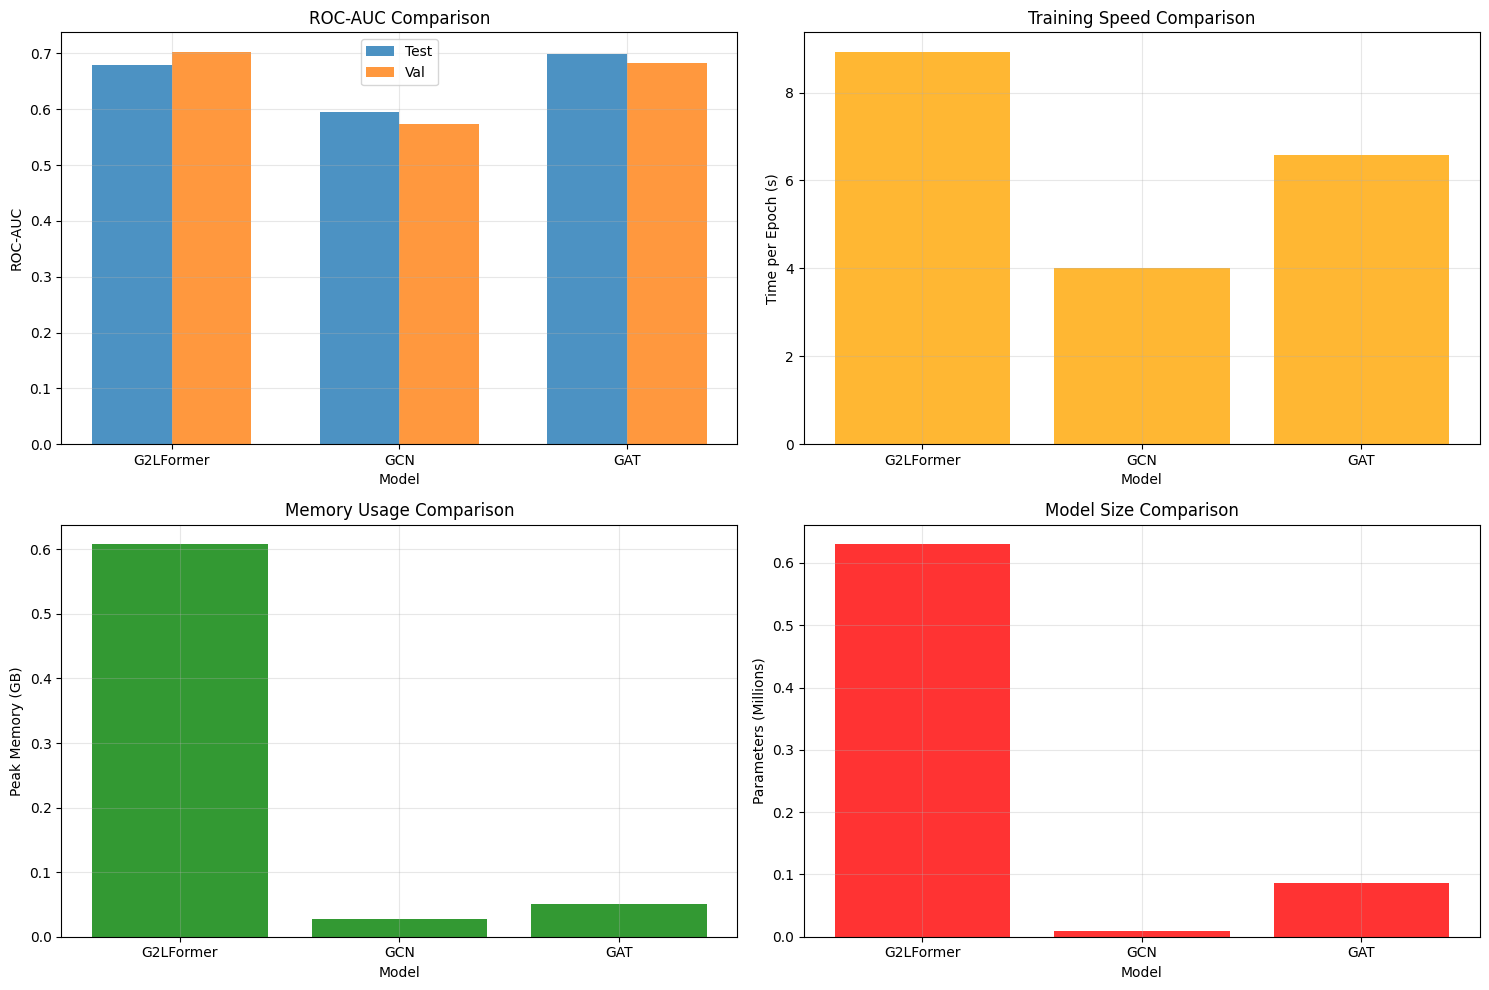

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Collect all performance metrics
comparison_data = {
    'Model': [],
    'Test ROC-AUC': [],
    'Test Accuracy': [],
    'Val ROC-AUC': [],
    'Avg Time/Epoch (s)': [],
    'Peak Memory (GB)': [],
    'Parameters': []
}

for name, model in models_to_eval:
    comparison_data['Model'].append(name)
    comparison_data['Test ROC-AUC'].append(test_results[name].get('roc_auc', 0))
    comparison_data['Test Accuracy'].append(test_results[name].get('accuracy', 0))
    
    # Get validation metrics from history
    if name == "G2LFormer":
        val_metrics = g2lformer_history['val_metrics'][-1]
        perf = g2lformer_perf
    elif name == "GCN":
        val_metrics = gcn_history['val_metrics'][-1]
        perf = gcn_perf
    else:  # GAT
        val_metrics = gat_history['val_metrics'][-1]
        perf = gat_perf
    
    comparison_data['Val ROC-AUC'].append(val_metrics.get('roc_auc', 0))
    comparison_data['Avg Time/Epoch (s)'].append(perf['avg_train_time'])
    comparison_data['Peak Memory (GB)'].append(perf['peak_memory_gb'])
    comparison_data['Parameters'].append(sum(p.numel() for p in model.parameters()))

# Create comparison DataFrame
df_comparison = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print("="*60)
print(df_comparison.to_string(index=False))
print("="*60)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ROC-AUC comparison
ax = axes[0, 0]
models = df_comparison['Model']
test_auc = df_comparison['Test ROC-AUC']
val_auc = df_comparison['Val ROC-AUC']
x = np.arange(len(models))
width = 0.35
ax.bar(x - width/2, test_auc, width, label='Test', alpha=0.8)
ax.bar(x + width/2, val_auc, width, label='Val', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)

# Training time comparison
ax = axes[0, 1]
ax.bar(models, df_comparison['Avg Time/Epoch (s)'], alpha=0.8, color='orange')
ax.set_xlabel('Model')
ax.set_ylabel('Time per Epoch (s)')
ax.set_title('Training Speed Comparison')
ax.grid(True, alpha=0.3)

# Memory usage comparison
ax = axes[1, 0]
ax.bar(models, df_comparison['Peak Memory (GB)'], alpha=0.8, color='green')
ax.set_xlabel('Model')
ax.set_ylabel('Peak Memory (GB)')
ax.set_title('Memory Usage Comparison')
ax.grid(True, alpha=0.3)

# Parameter count comparison
ax = axes[1, 1]
ax.bar(models, df_comparison['Parameters'] / 1e6, alpha=0.8, color='red')
ax.set_xlabel('Model')
ax.set_ylabel('Parameters (Millions)')
ax.set_title('Model Size Comparison')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Load Saved Models

Models are automatically saved to the `./checkpoints/` directory. You can load them later for evaluation or continued training.

In [18]:
from utils.load_model import load_trained_model, load_training_results

# Example: Load a saved model
# loaded_g2lformer = load_trained_model(
#     './checkpoints/G2LFormer_MolHIV_best.pt',
#     model_class='g2lformer',
#     input_dim=input_dim
# )

# Example: Load training results
# results = load_training_results('./checkpoints/G2LFormer_MolHIV_results.json')
# print("Training history and performance stats loaded")